***Linear Regression*** **kullanabilmek için**:

- **Correlation Olması Gerekiyor**

- **Residualların Normal Dağılımı Olması Gerekiyor**

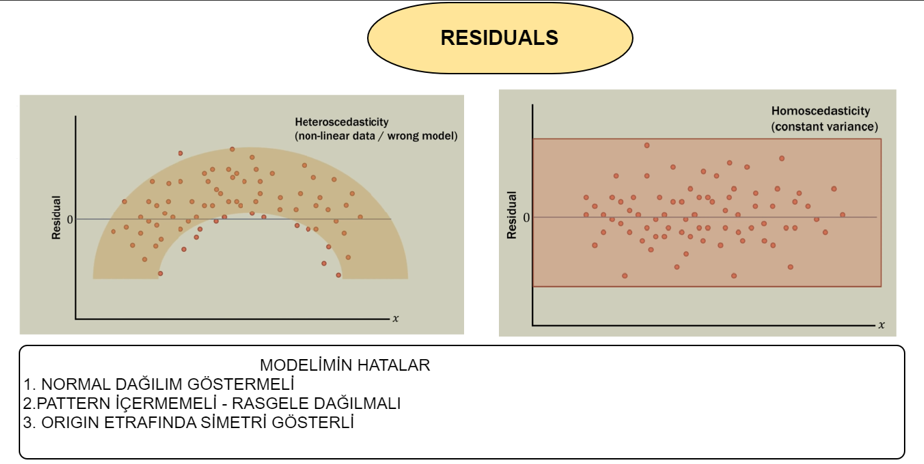

# Multiple Linear Regression and Regression Error Metrics

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

plt.rcParams["figure.figsize"] = (10, 6)

import warnings
warnings.filterwarnings('ignore')

**y = b0 + b1X1 + b2X2 + b3X3**

In [2]:
df = pd.read_csv("Advertising.csv")
df

TV  radio  newspaper  sales
0    230.1   37.8       69.2   22.1
1     44.5   39.3       45.1   10.4
2     17.2   45.9       69.3    9.3
3    151.5   41.3       58.5   18.5
4    180.8   10.8       58.4   12.9
..     ...    ...        ...    ...
195   38.2    3.7       13.8    7.6
196   94.2    4.9        8.1    9.7
197  177.0    9.3        6.4   12.8
198  283.6   42.0       66.2   25.5
199  232.1    8.6        8.7   13.4

[200 rows x 4 columns]

## EDA

In [3]:
df.shape

(200, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [5]:
df.describe().T

count      mean        std  min     25%     50%      75%    max
TV         200.0  147.0425  85.854236  0.7  74.375  149.75  218.825  296.4
radio      200.0   23.2640  14.846809  0.0   9.975   22.90   36.525   49.6
newspaper  200.0   30.5540  21.778621  0.3  12.750   25.75   45.100  114.0
sales      200.0   14.0225   5.217457  1.6  10.375   12.90   17.400   27.0

In [6]:
df.isnull().sum()

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

In [7]:
# !pip install missingno

In [8]:
import missingno as msno # Eksik verilerin yapısını ve dağılımını görselleştirir

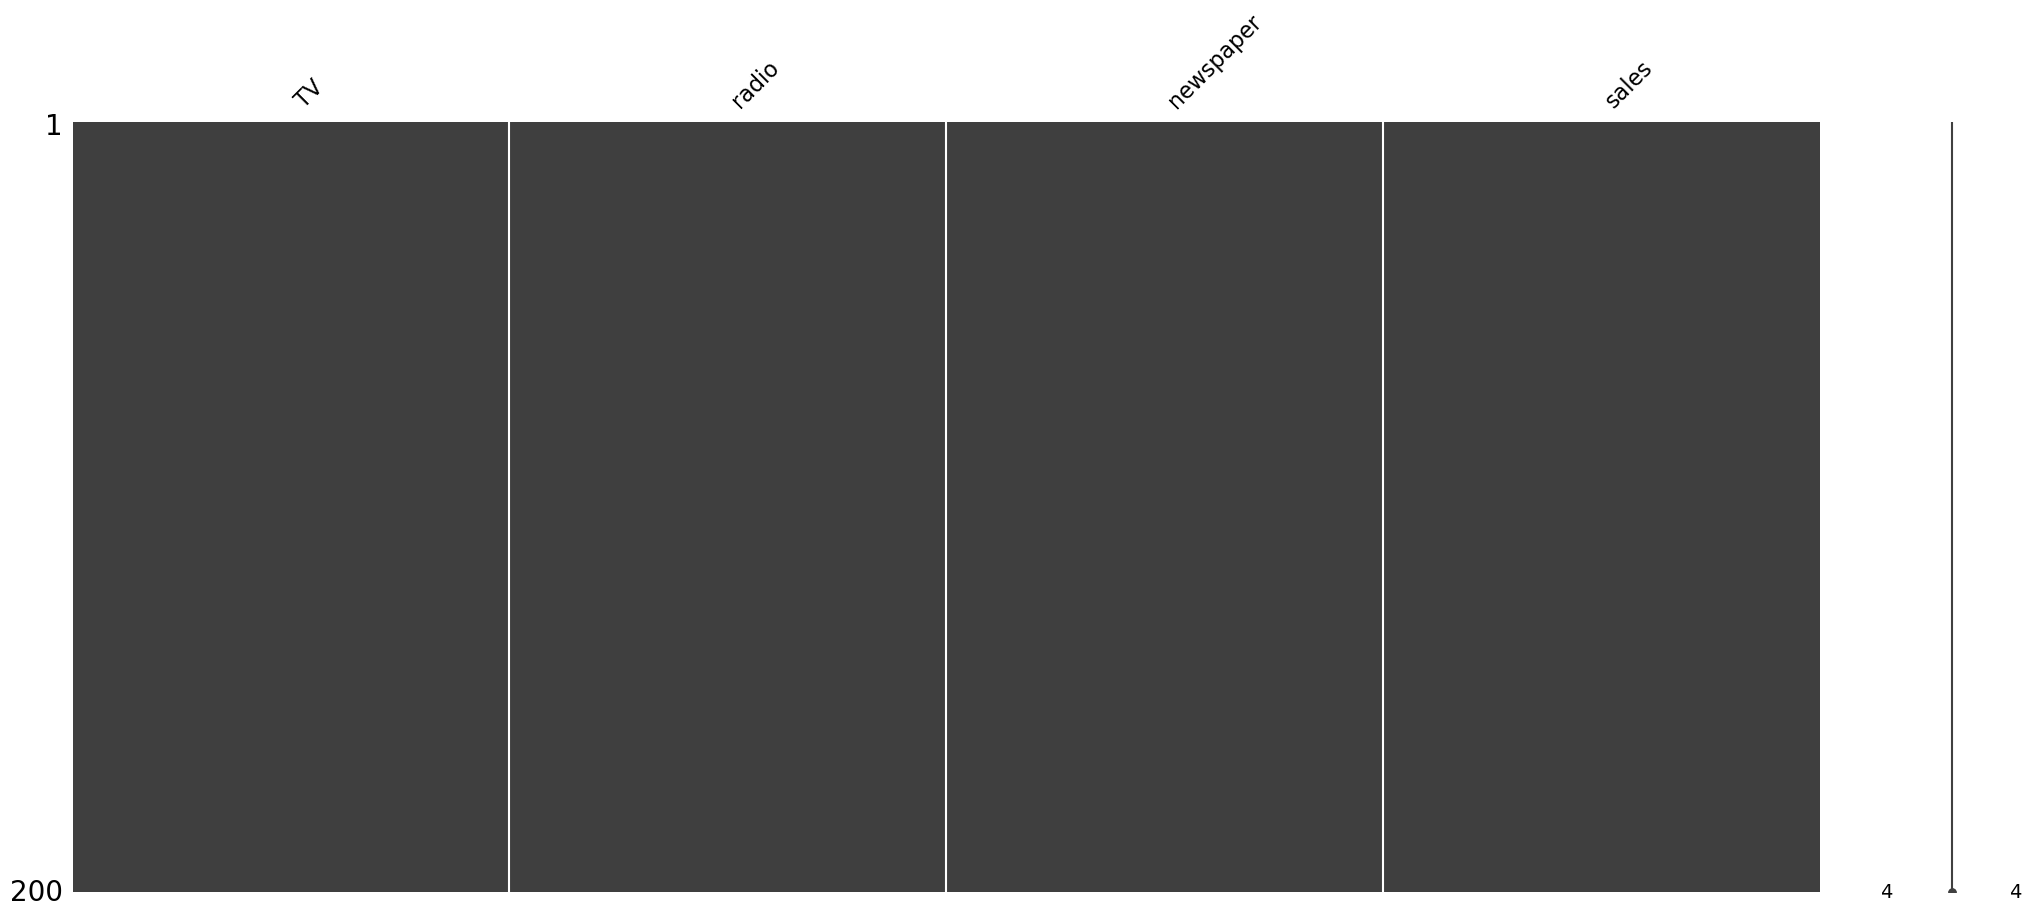

In [9]:
msno.matrix(df);

## null değerler olduğunda örnek bir çıktı:
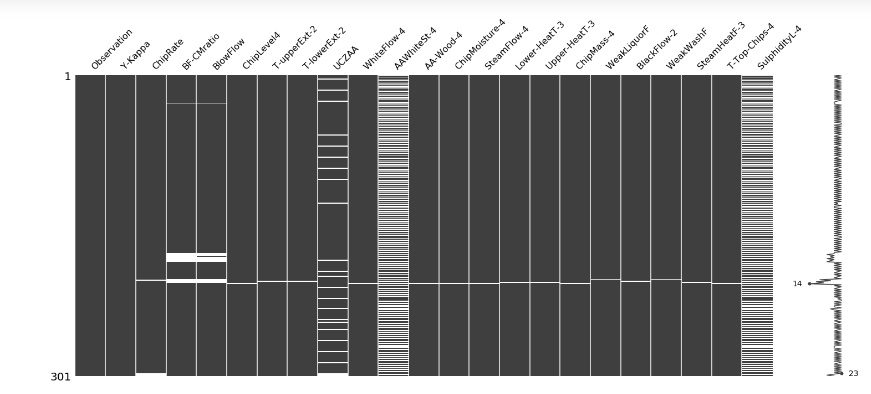

In [10]:
df.sort_values(by="sales", ascending=False)

TV  radio  newspaper  sales
175  276.9   48.9       41.8   27.0
183  287.6   43.0       71.8   26.2
198  283.6   42.0       66.2   25.5
98   289.7   42.3       51.2   25.4
147  243.2   49.0       44.3   25.4
..     ...    ...        ...    ...
108   13.1    0.4       25.6    5.3
78     5.4   29.9        9.4    5.3
8      8.6    2.1        1.0    4.8
155    4.1   11.6        5.7    3.2
130    0.7   39.6        8.7    1.6

[200 rows x 4 columns]

In [11]:
# !pip install summarytools

In [12]:
from summarytools import dfSummary
dfSummary(df)

In [13]:
# !pip install ydata_profiling

In [14]:
# Load the ydata_profiling package
from ydata_profiling import ProfileReport
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**----------------------------------------------------------------------------------------------------------------------------------**

**mean** ve **std** değerlerinin birbirine yakınlığının **outlier** tespitindeki önemi hakkında bir örnek:

In [15]:
print(np.mean([100,110,120,115]))
print(np.std([100,110,120,115]))

111.25
7.39509972887452


In [16]:
print(np.mean([100,110,120,700]))
print(np.std([100,110,120,700]))

257.5
255.57533136044253


In [17]:
print(np.mean([100,110,120,900]))
print(np.std([100,110,120,900]))

307.5
342.153109002388


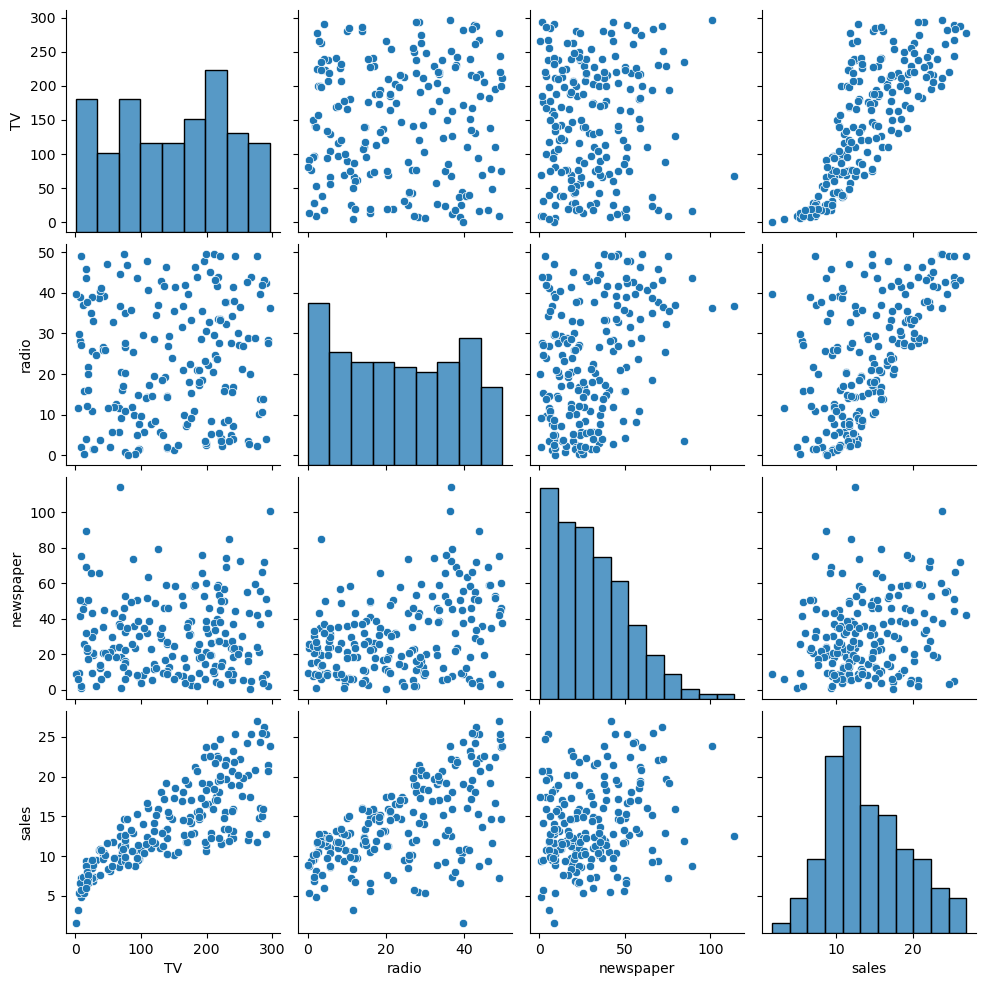

In [18]:
sns.pairplot(df);

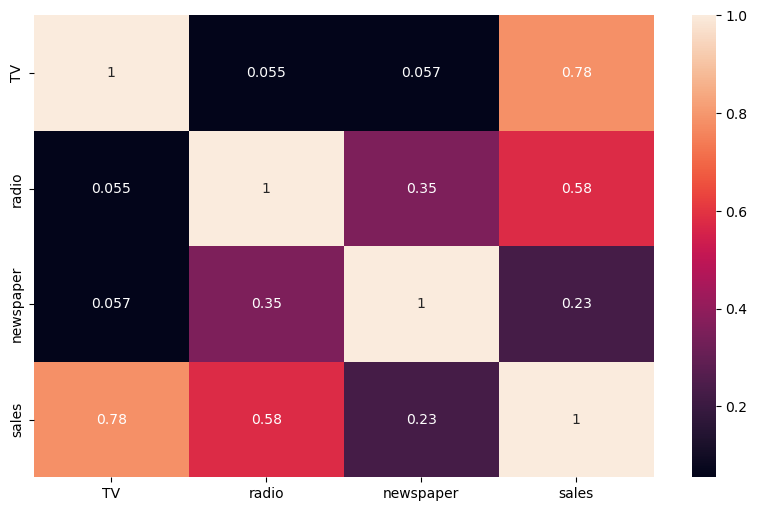

In [19]:
sns.heatmap(df.corr(), annot=True);

In [20]:
from scipy.stats import skew

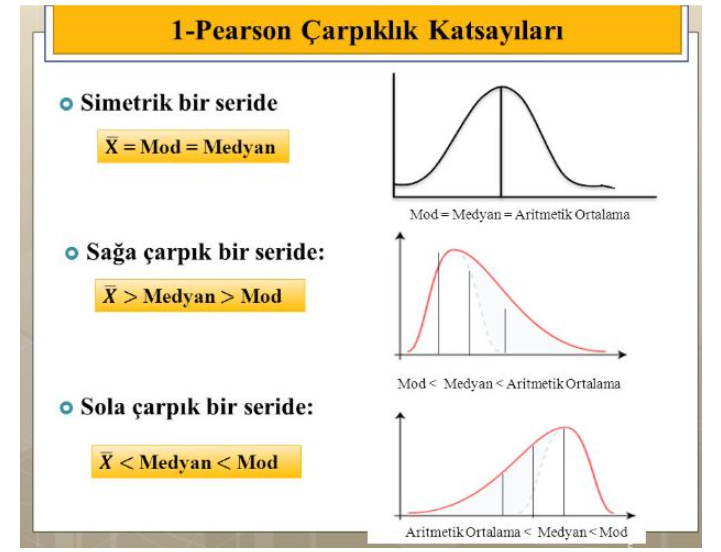

In [21]:
# skewness tespiti için bir döngü
for i in df.drop(columns = "sales").columns:
    print(i, skew(df[i]))
# sales sütunu haricindeki tüm feature ların skewness degerini hesplar

TV -0.06932836662244649
radio 0.0934668451108453
newspaper 0.8879959753085498


- **-0.5 ile +0.5 arasındaki skewnes değerlerinde dağılımın kabaca simetrik olduğu kabul edilebilir.**

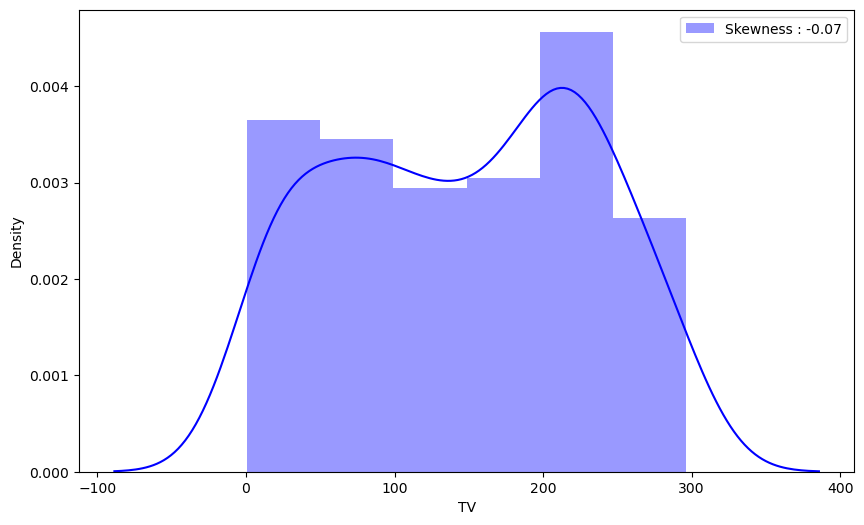

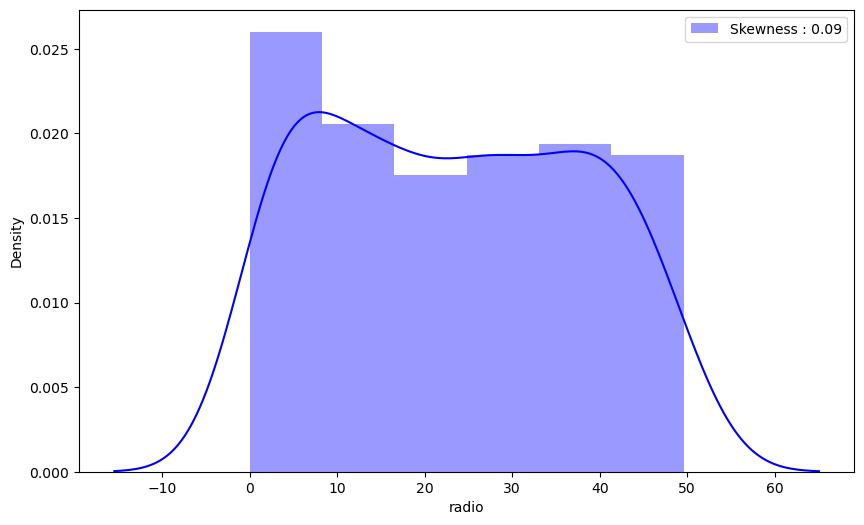

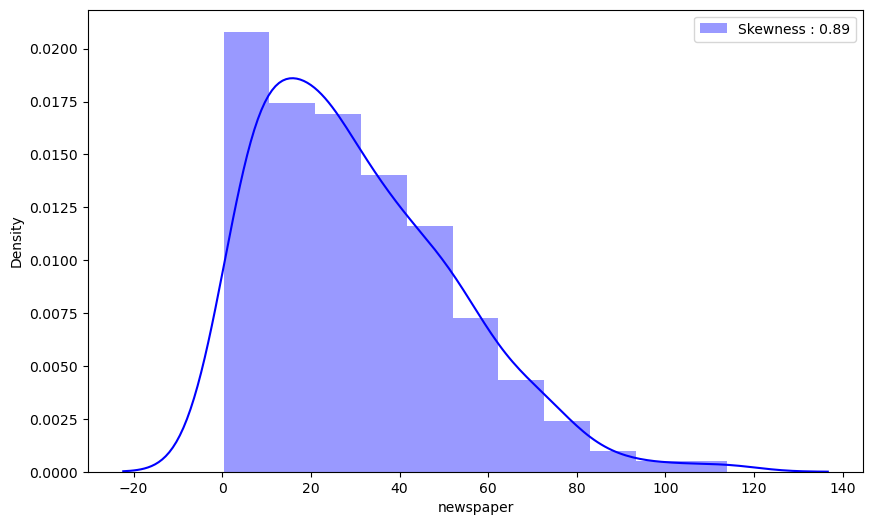

In [22]:
for j in df.drop(columns = "sales").columns:     #"sales" sütunu dataframe'den kaldırılıyor
    g = sns.distplot(df[j], color= "b", label= "Skewness : %.2f"%(df[j].skew()))   #  j sütununa ait veri dağılımı grafiği çiziliyor. grafiğin üzerinde gösterilen etiketi oluşturur. Etiket, o sütunun çarpıklık değerini (skewness) içerir
    g = g.legend(loc= "best")   #  grafiğin üzerine eklenen etiketin konumunu en iyi yere yerleştirmes
    plt.show()

In [23]:
df.corr()

TV     radio  newspaper     sales
TV         1.000000  0.054809   0.056648  0.782224
radio      0.054809  1.000000   0.354104  0.576223
newspaper  0.056648  0.354104   1.000000  0.228299
sales      0.782224  0.576223   0.228299  1.000000

# Train | Test Split

**Train ve Test Olarak Ayırmamızdaki Amaç**: Modelin eğitim sırasında görmediği yeni verilere ne kadar iyi performans gösterdiğini anlamaktır.

***Train Seti***: Modelin öğrenmesi için kullanılan veri kısmıdır. Model, bu veriler üzerinde eğitilir ve öğrenme sürecinde bu verilerin özelliklerini ve hedef değişkenler arasındaki ilişkileri keşfeder.

***Test Seti***: Modelin eğitim sırasında hiç görmediği verileri içerir. Model eğitildikten sonra, bu set üzerinde test edilir. Bu, modelin genelleme yeteneğini, yani daha önce görmediği verilere nasıl tepki verdiğini değerlendirmek için kullanılır.

**ML için scikit-learn kütüphanesi kullanılır**

In [24]:
X = df.drop(columns="sales") # Target'ı düşürüp Independent variable'ları X'e atadık
y = df["sales"] # Target
print(X,y)

        TV  radio  newspaper
0    230.1   37.8       69.2
1     44.5   39.3       45.1
2     17.2   45.9       69.3
3    151.5   41.3       58.5
4    180.8   10.8       58.4
..     ...    ...        ...
195   38.2    3.7       13.8
196   94.2    4.9        8.1
197  177.0    9.3        6.4
198  283.6   42.0       66.2
199  232.1    8.6        8.7

[200 rows x 3 columns] 0      22.1
1      10.4
2       9.3
3      18.5
4      12.9
       ... 
195     7.6
196     9.7
197    12.8
198    25.5
199    13.4
Name: sales, Length: 200, dtype: float64


In [25]:
# Data setini random olarak eğitim (training) ve test (testing) setleri olarak ayırmak için kullanılır

from sklearn.model_selection import train_test_split 

***X_train***: Eğitim veri setinin özelliklerini (features) içerir.

***X_test***: Test veri setinin özelliklerini (features) içerir.

***y_train***: Eğitim veri setinin etiketlerini (labels/targets) içerir.

***y_test***: Test veri setinin etiketlerini (labels/targets) içerir.

train_test_split(X, y, test_size=0.3, random_state=42): Bu fonksiyon çağrısı ile X (özellikler) ve y (etiketler) veri setleri 
rastgele olarak eğitim ve test alt kümelerine ayrılır.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

# Burada test|train'i ne kadar ayıracağımızı sadece test_size parametresini kullanarak ayırırız.
# test size = 0.3 - train size = 0.7

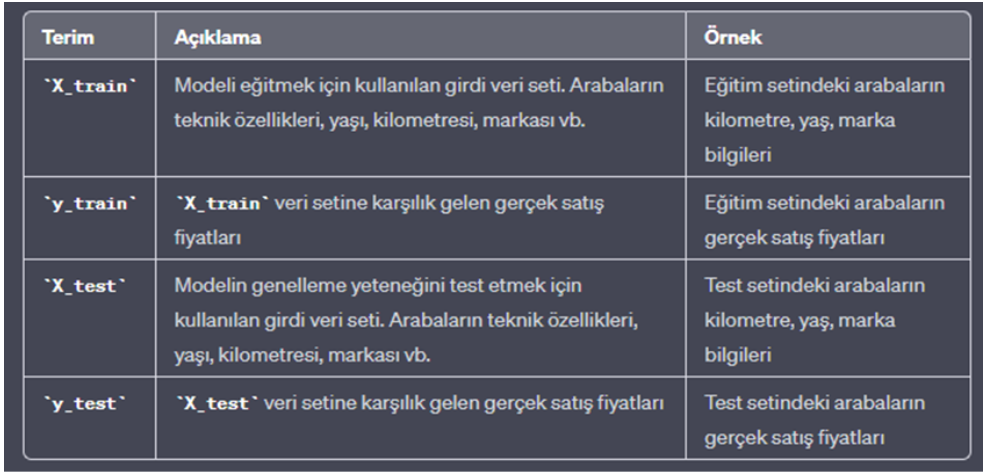

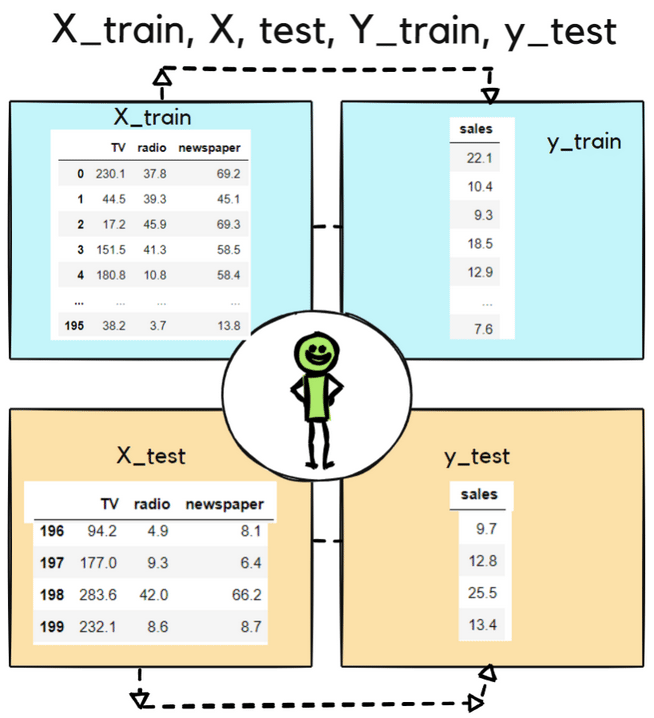

In [27]:
df.sample(5)

TV  radio  newspaper  sales
108   13.1    0.4       25.6    5.3
87   110.7   40.6       63.2   16.0
18    69.2   20.5       18.3   11.3
48   227.2   15.8       49.9   14.8
25   262.9    3.5       19.5   12.0

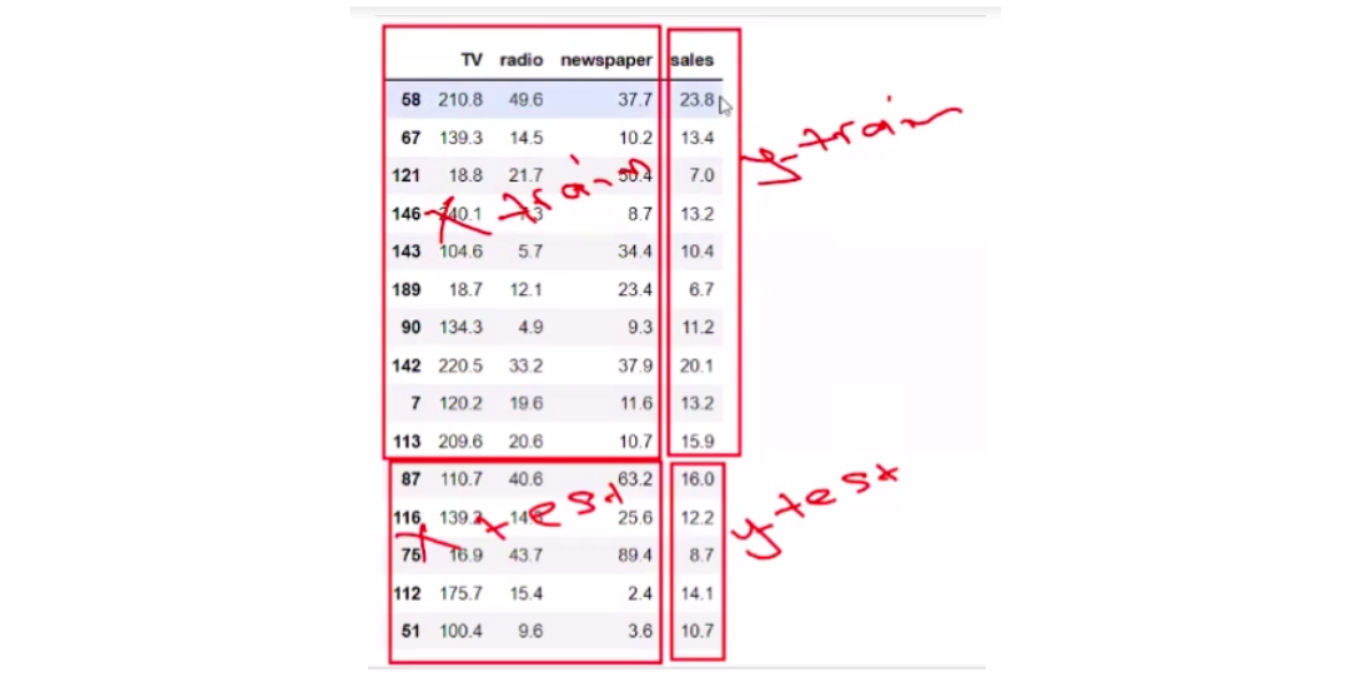

***y = aX1 + bX2 + cX3***

Train işleminde makine öğrendiği (a,b,c)'leri test setinde uygulayıp prediction yapar

***Örneğin***
Üstteki fotoğraftaki X_test 51. satır üzerinden örnek yapalım:
**Makine X_train datasından**
- a = 3
- b = 2
- c = 5 değerlerini öğrenmiş olsun.

değerlerini öğrenmiş olsun. Bu durumda

**y_pred = (3 x 100.4) + (2 x 9.6) + (5 x 3.6)** denklemini uygular.

In [28]:
# Train ve test setlerinin shape'leri

print("X Train features shape: {}\ny Train features shape: {}\nX Test features shape : {}\nY Test features shape : {}".format
      (X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X Train features shape: (140, 3)
y Train features shape: (140,)
X Test features shape : (60, 3)
Y Test features shape : (60,)


In [29]:
print("Train features shape: ", X_train.shape)
print("Train target shape: ", y_train.shape)
print("Test features shape: ", X_test.shape)
print("Test target shape: ", y_test.shape)

Train features shape:  (140, 3)
Train target shape:  (140,)
Test features shape:  (60, 3)
Test target shape:  (60,)


In [30]:
y_train

169    15.0
97     15.5
31     11.9
12      9.2
35     12.8
       ... 
106     7.2
14     19.0
92     19.4
179    12.6
102    14.8
Name: sales, Length: 140, dtype: float64

In [31]:
X_test

TV  radio  newspaper
95   163.3   31.6       52.9
15   195.4   47.7       52.9
30   292.9   28.3       43.2
158   11.7   36.9       45.2
128  220.3   49.0        3.2
115   75.1   35.0       52.7
69   216.8   43.9       27.2
170   50.0   11.6       18.4
174  222.4    3.4       13.1
45   175.1   22.5       31.5
66    31.5   24.6        2.2
182   56.2    5.7       29.7
165  234.5    3.4       84.8
78     5.4   29.9        9.4
186  139.5    2.1       26.6
177  170.2    7.8       35.2
56     7.3   28.1       41.4
152  197.6   23.3       14.2
82    75.3   20.3       32.5
68   237.4   27.5       11.0
124  229.5   32.3       74.2
16    67.8   36.6      114.0
148   38.0   40.3       11.9
93   250.9   36.5       72.3
65    69.0    9.3        0.9
60    53.5    2.0       21.4
84   213.5   43.0       33.8
67   139.3   14.5       10.2
125   87.2   11.8       25.9
132    8.4   27.2        2.1
9    199.8    2.6       21.2
18    69.2   20.5       18.3
55   198.9   49.4       60.0
75    16.9   43.7       89.4
150  280.7   13.9       37.0
104  238.2   34.3        5.3
135   48.3   47.0        8.5
137  273.7   28.9       59.7
164  117.2   14.7        5.4
76    27.5    1.6       20.7
79   116.0    7.7       23.1
197  177.0    9.3        6.4
38    43.1   26.7       35.1
24    62.3   12.6       18.3
122  224.0    2.4       15.6
195   38.2    3.7       13.8
29    70.6   16.0       40.8
19   147.3   23.9       19.1
143  104.6    5.7       34.4
86    76.3   27.5       16.0
114   78.2   46.8       34.5
173  168.4    7.1       12.8
5      8.7   48.9       75.0
126    7.8   38.9       50.6
117   76.4    0.8       14.8
73   129.4    5.7       31.3
140   73.4   17.0       12.9
98   289.7   42.3       51.2
172   19.6   20.1       17.0
96   197.6    3.5        5.9

# Model Fitting | Compare Actual | Predicted Labels

**Model Fitting**

Bir makine öğrenimi modelinin eğitim veri seti üzerindeki performansını optimize ederek, verilen görevi en iyi şekilde yerine getirebilmesi sürecini ifade eder.

Model fitting sürecinde amaç, underfitting ve overfitting arasında bir denge bulmak ve modelin hem eğitim verilerine iyi uymasını (yüksek eğitim doğruluğu) hem de yeni ve görülmemiş verilere iyi genelleme yapabilmesini (yüksek test doğruluğu) sağlamaktır. 

In [32]:
from sklearn.linear_model import LinearRegression

In [33]:
model = LinearRegression() 

# Algoritmayı prediction'da herhangi bir hata almamak için best practice olarak bir variable'a atıyoruz

In [34]:
# ".fit(X,y)" function'ı model'i fit etmemizi sağlar

model.fit(X_train, y_train) # Modeli fit ederken x olarak X_train'i, y olarak y_train'i kullan

# Model X_train'in featurlarını kullanarak y_train'in label'larını predict etmeyi öğrenecek

LinearRegression()

In [35]:
# ".predict(X)" function'ı train'den öğrendiklerini test datasında uygulayıp prediction yapmamızı sağlar

y_pred = model.predict(X_test)
y_pred

array([16.5653963 , 21.18822792, 21.55107058, 10.88923816, 22.20231988,
       13.35556872, 21.19692502,  7.35028523, 13.27547079, 15.12449511,
        9.01443026,  6.52542825, 14.30205991,  8.97026042,  9.45679576,
       12.00454351,  8.91549403, 16.15619251, 10.29582883, 18.72473553,
       19.76821818, 13.77469028, 12.49638908, 21.53501762,  7.60860741,
        5.6119801 , 20.91759483, 11.80627665,  9.08076637,  8.51412012,
       12.17604891,  9.9691939 , 21.73008956, 12.77770578, 18.1011362 ,
       20.07590796, 14.26202556, 20.93826535, 10.83938827,  4.38190607,
        9.51332406, 12.40486324, 10.17045434,  8.09081363, 13.16388427,
        5.2243552 ,  9.28893833, 14.09330719,  8.69024497, 11.66119763,
       15.71848432, 11.63156862, 13.35360735, 11.1531472 ,  6.33636845,
        9.76157954,  9.4195714 , 24.25516546,  7.69519137, 12.15317572])

**--------------------------------------------------------------------**

**y_pred = b1 * Tv + b2 * radio + b3 * newspaper + b0**

**--------------------------------------------------------------------**

In [36]:
# ".coef_" function'ı modelin katsayılarını verir

model.coef_

# (TV'nin katsayısı: 0.04, radio: 0.199, newspaper: 0.006)

array([0.04405928, 0.1992875 , 0.00688245])

In [37]:
# ".feature_names_in_" function'ı Yukardaki katsayıların karşılık geldiği feature'ları verir

model.feature_names_in_

array(['TV', 'radio', 'newspaper'], dtype=object)

In [38]:
# X = 0 olduğundaki sabit sayıyı verir

model.intercept_

2.70894909251591

In [39]:
# Herhangi bir satırdaki değerler için manuel bir şekilde y_pred hesaplayalım.

sum(X_test.loc[95]*model.coef_) + model.intercept_

# Bu deger y_test'in' 95. satırının değeri olan 16.9 gerçek değerinin manuel olarak tahmin edilen halidir


16.565396297434837

In [40]:
# Actual: Gerçek değer
# Pred: Tahmin edilen değer
# Residual: Gerçek değer - Tahmin edilen değer

my_dict = {"Actual": y_test, "Pred": y_pred, "Residual": y_test - y_pred}

In [41]:
comparing = pd.DataFrame(my_dict)
comparing

Actual       Pred  Residual
95     16.9  16.565396  0.334604
15     22.4  21.188228  1.211772
30     21.4  21.551071 -0.151071
158     7.3  10.889238 -3.589238
128    24.7  22.202320  2.497680
115    12.6  13.355569 -0.755569
69     22.3  21.196925  1.103075
170     8.4   7.350285  1.049715
174    11.5  13.275471 -1.775471
45     14.9  15.124495 -0.224495
66      9.5   9.014430  0.485570
182     8.7   6.525428  2.174572
165    11.9  14.302060 -2.402060
78      5.3   8.970260 -3.670260
186    10.3   9.456796  0.843204
177    11.7  12.004544 -0.304544
56      5.5   8.915494 -3.415494
152    16.6  16.156193  0.443807
82     11.3  10.295829  1.004171
68     18.9  18.724736  0.175264
124    19.7  19.768218 -0.068218
16     12.5  13.774690 -1.274690
148    10.9  12.496389 -1.596389
93     22.2  21.535018  0.664982
65      9.3   7.608607  1.691393
60      8.1   5.611980  2.488020
84     21.7  20.917595  0.782405
67     13.4  11.806277  1.593723
125    10.6   9.080766  1.519234
132     5.7   8.514120 -2.814120
9      10.6  12.176049 -1.576049
18     11.3   9.969194  1.330806
55     23.7  21.730090  1.969910
75      8.7  12.777706 -4.077706
150    16.1  18.101136 -2.001136
104    20.7  20.075908  0.624092
135    11.6  14.262026 -2.662026
137    20.8  20.938265 -0.138265
164    11.9  10.839388  1.060612
76      6.9   4.381906  2.518094
79     11.0   9.513324  1.486676
197    12.8  12.404863  0.395137
38     10.1  10.170454 -0.070454
24      9.7   8.090814  1.609186
122    11.6  13.163884 -1.563884
195     7.6   5.224355  2.375645
29     10.5   9.288938  1.211062
19     14.6  14.093307  0.506693
143    10.4   8.690245  1.709755
86     12.0  11.661198  0.338802
114    14.6  15.718484 -1.118484
173    11.7  11.631569  0.068431
5       7.2  13.353607 -6.153607
126     6.6  11.153147 -4.553147
117     9.4   6.336368  3.063632
73     11.0   9.761580  1.238420
140    10.9   9.419571  1.480429
98     25.4  24.255165  1.144835
172     7.6   7.695191 -0.095191
96     11.7  12.153176 -0.453176

In [42]:
result_sample = comparing.sample(25)
result_sample

Actual       Pred  Residual
86     12.0  11.661198  0.338802
158     7.3  10.889238 -3.589238
165    11.9  14.302060 -2.402060
84     21.7  20.917595  0.782405
124    19.7  19.768218 -0.068218
18     11.3   9.969194  1.330806
30     21.4  21.551071 -0.151071
114    14.6  15.718484 -1.118484
164    11.9  10.839388  1.060612
115    12.6  13.355569 -0.755569
125    10.6   9.080766  1.519234
177    11.7  12.004544 -0.304544
143    10.4   8.690245  1.709755
150    16.1  18.101136 -2.001136
197    12.8  12.404863  0.395137
98     25.4  24.255165  1.144835
60      8.1   5.611980  2.488020
56      5.5   8.915494 -3.415494
78      5.3   8.970260 -3.670260
68     18.9  18.724736  0.175264
173    11.7  11.631569  0.068431
93     22.2  21.535018  0.664982
104    20.7  20.075908  0.624092
128    24.7  22.202320  2.497680
135    11.6  14.262026 -2.662026

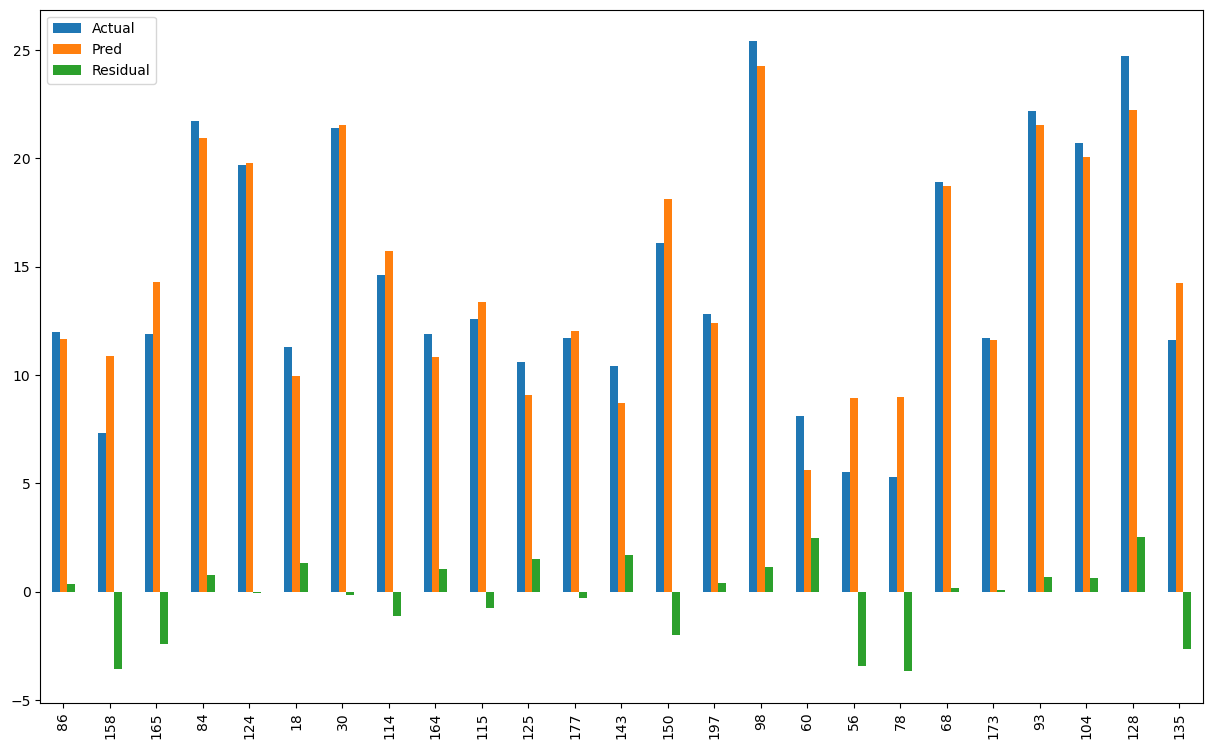

In [43]:
result_sample.plot(kind="bar", figsize=(15,9));

# Error Metrics

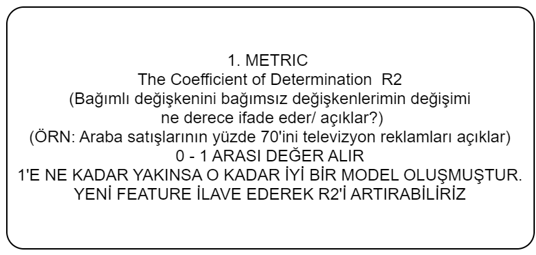

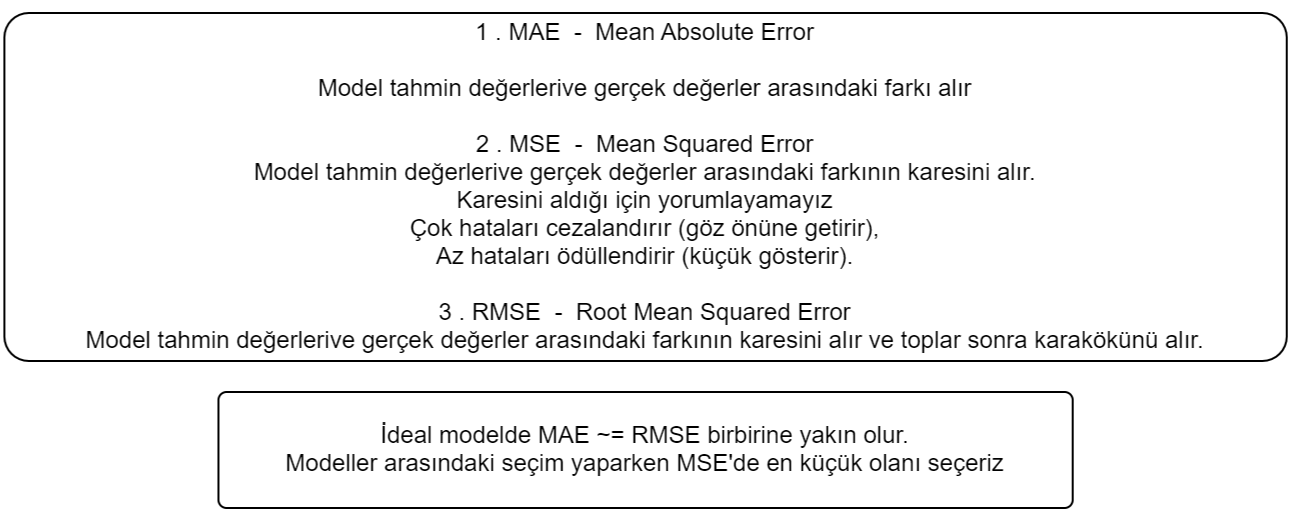

In [44]:
# Modelin performansını ölçmek için kullanılan error metrikleri
# RMSE'yi manuel hesaplayacağız 

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

- **R2 Score** modelin başarı oranını gösterir
- **1'e yakın olmasını isteriz**

In [45]:
R2_score = r2_score(y_test, y_pred)
R2_score

0.8609466508230368

- **Mean Absolute Error (MAE)** residualların mutlak değerini alıp gözlem sayısına böler
- **0'a ne kadar yakınsa o kadar iyidir**

In [46]:
# Mean Absolute Error (MAE) Hesabı

mae = mean_absolute_error(y_test, y_pred)
mae

1.5116692224549084

- **Mean Squared Error (MSE)** residualların karelerinin ortalamasını alır
- **0'a ne kadar yakınsa o kadar iyidir**

In [47]:
# Mean Squared Error (MSE) Hesabı

mse = mean_squared_error(y_test, y_pred)
mse

3.79679723671522

- **Root Mean Squared Error (RMSE)** MSE'nin kareköküdür
- **0'a ne kadar yakınsa o kadar iyidir**
- **Errorları daha fazla cezalandırdığı için MSE'ye göre daha düşük çıkar**

In [48]:
# Root Mean Squared Error - RMSE Hesabı

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

1.9485372043446387

In [49]:
# Ortalama Hata Oranı

sales_mean = df["sales"].mean()
sales_mean

14.0225

In [50]:
# MAE Hata Oranı
# 0'a ne kadar yakınsa o kadar iyi

mae / sales_mean

0.10780311802138764

In [51]:
# RMSE Hata Oranı

rmse / sales_mean

0.138957903679418

# Adjusted R2 Score (Düzeltimiş R2 Değeri)

n = gözlem sayım (data noktası sayısı)

p = feature

Adjusted R2 = 1 - [(1 - R2) * (n - 1) / (n - p - 1)]

In [52]:
def adj_r2(y_test, y_pred, df):
    r2 = r2_score(y_test, y_pred)    #R2 score
    n = df.shape[0]      # number of observations gözlem
    p =df.shape[1]-1    # number of indep. variable = feature
    adj_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
    return adj_r2

In [53]:
adj_r2(y_test, y_pred, df)

0.8588182832335934

**Önceki r2 degerine yakın çıktı. çünkü zaten 3 feature vardı. alt örnekte feature sayısını abartıı vererek adjusted etkisini görelim**

In [54]:
def adj_r2(y_test, y_pred, df):
    r2 = r2_score(y_test, y_pred)
    n = df.shape[0]   # number of observations
    p = 100 # number of independent variables ..feature sayısıı 100 aldık
    adj_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
    return adj_r2

In [55]:
adj_r2(y_test, y_pred, df)

0.7204887223614578

**Bir görüşe göre, her eklenen feature için 10-15 gözlem satırı daha eklenmelidir**

# Evalutaion Model

In [56]:
# Error metricleri hesaplayan ve yazan kod blogu
def eval_metric(actual, pred):
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    R2_score = r2_score(actual, pred)
    print("Model testing performance: ")
    print("---------------------------")
    print(f"R2_score \t: {R2_score}")
    print(f"MAE \t\t: {mae}")
    print(f"MSE \t\t: {mse}")
    print(f"RMSE \t\t: {rmse}")

In [57]:
eval_metric(y_test, y_pred)

Model testing performance: 
---------------------------
R2_score 	: 0.8609466508230368
MAE 		: 1.5116692224549084
MSE 		: 3.79679723671522
RMSE 		: 1.9485372043446387


**Overfitting kontrolü için train data'daki R2'yi bulalım ve yukarıdaki test R2(0.86) ile karşılaştıralım**

In [58]:
# X_train degerlerini prediction yapacağız
y_train_pred = model.predict(X_train)

In [59]:
eval_metric(y_train, y_train_pred)

Model testing performance: 
---------------------------
R2_score 	: 0.9055159502227753
MAE 		: 1.158150294807253
MSE 		: 2.4793551789057866
RMSE 		: 1.574596830590544


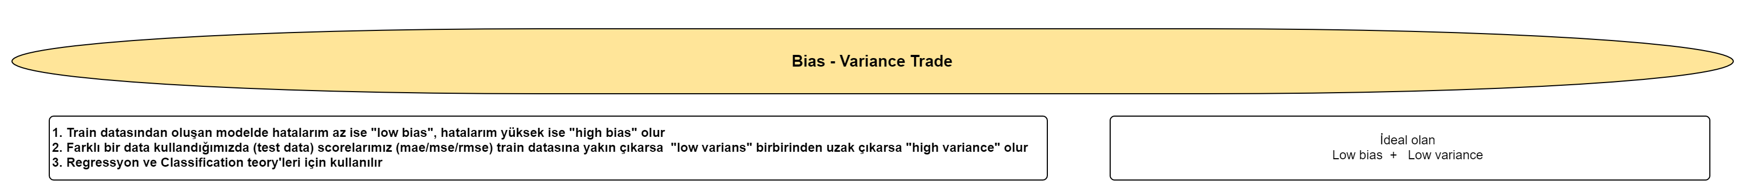

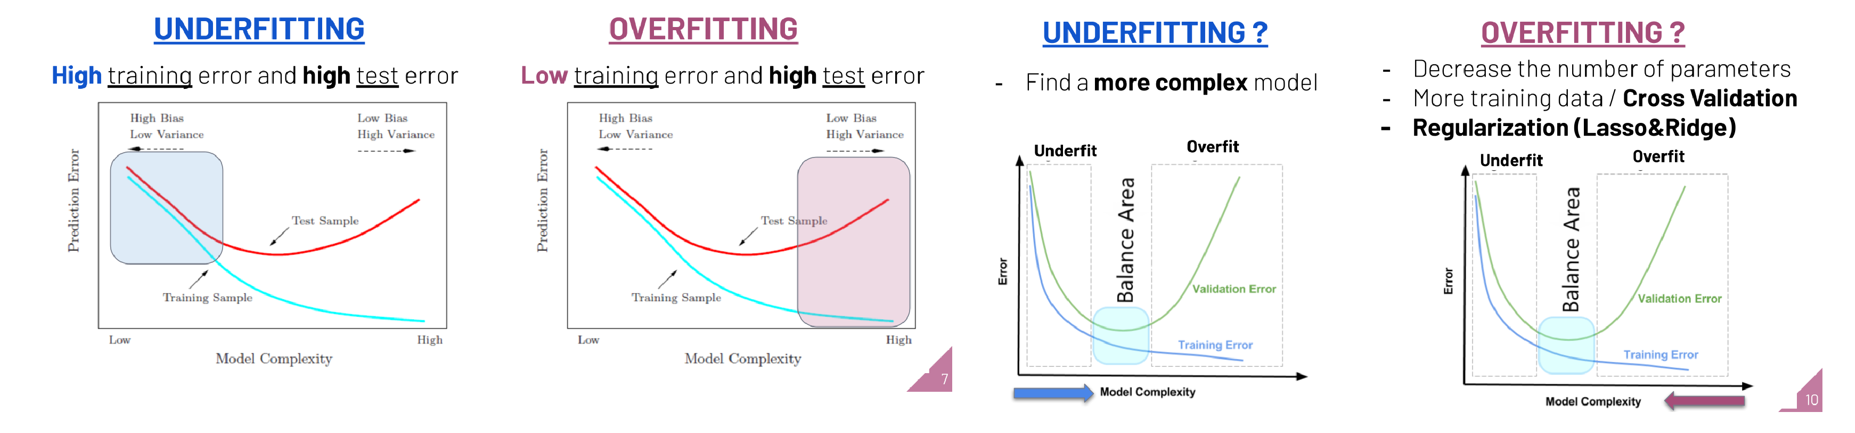

In [60]:
residuals = y_test - y_pred

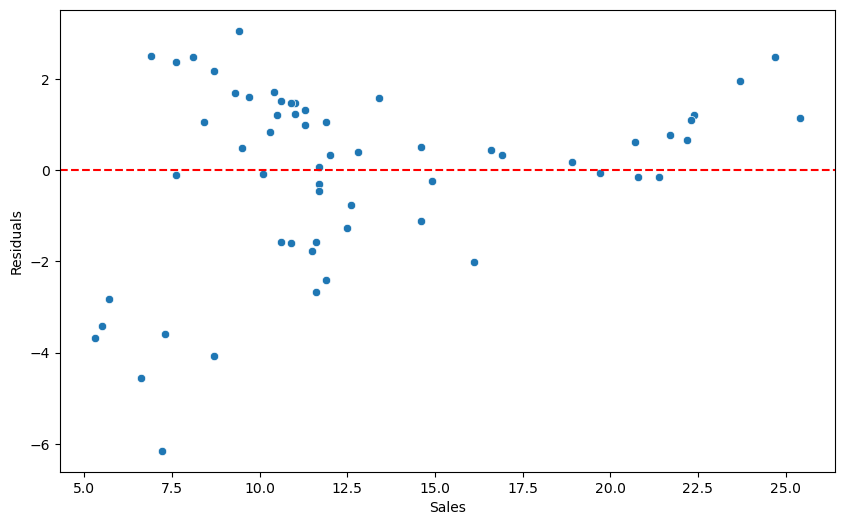

In [61]:
plt.figure(figsize=(10,6))

sns.scatterplot(x=y_test, y=residuals)

plt.xlabel("Sales")
plt.ylabel("Residuals")
plt.axhline(y=0, color="r", linestyle="--");

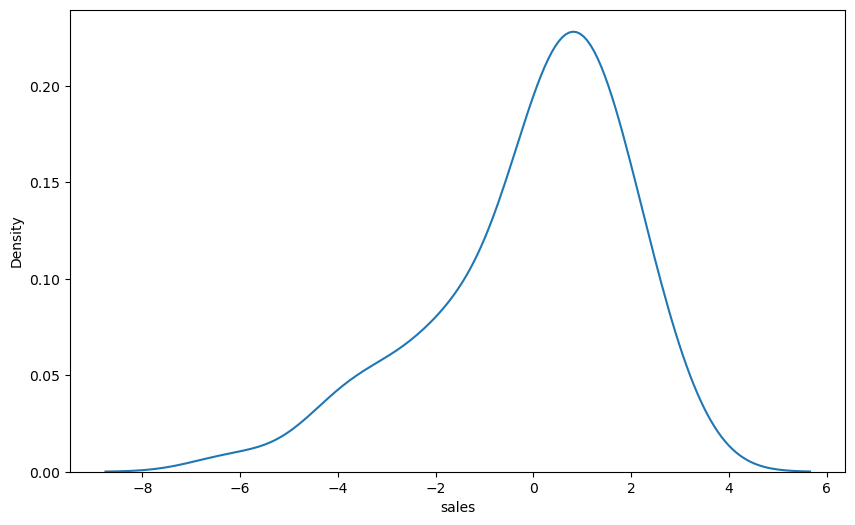

In [62]:
sns.kdeplot(residuals);

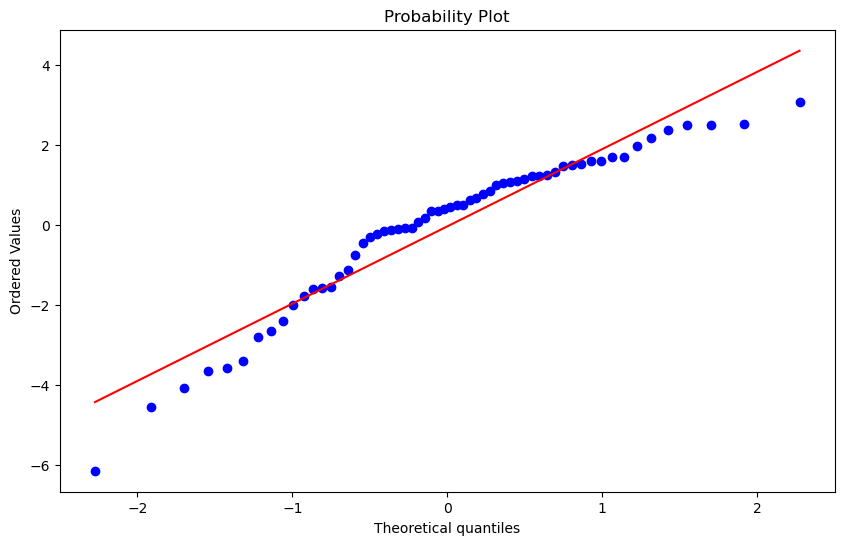

In [63]:
stats.probplot(residuals, dist="norm", plot=plt);

In [64]:
skew(residuals)

-0.9865673346742742

In [65]:
# !pip install yellowbrick
from yellowbrick.regressor import ResidualsPlot

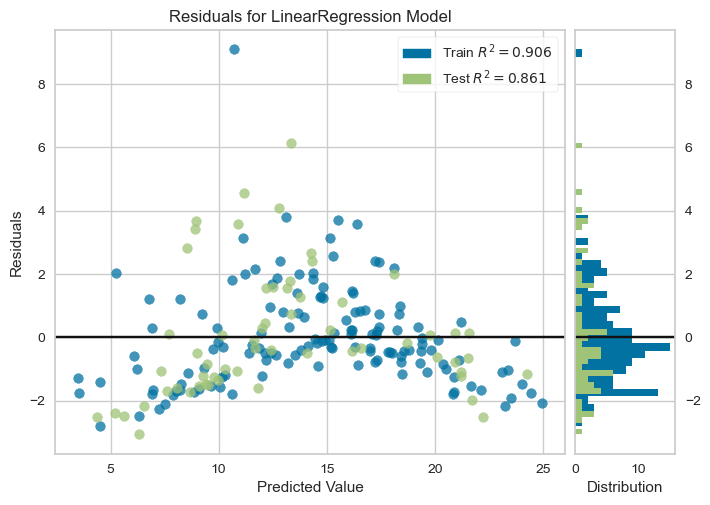

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [66]:
model = LinearRegression()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

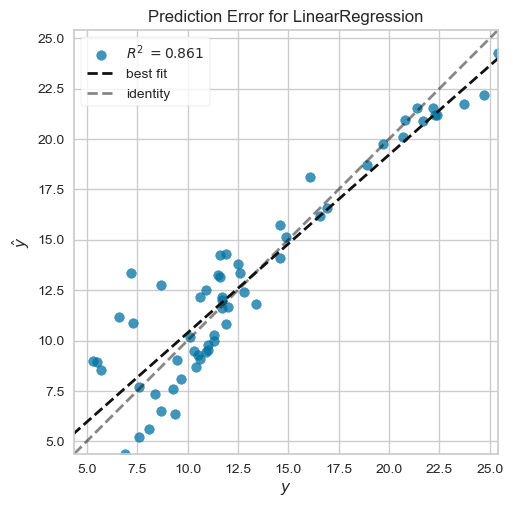

<Axes: title={'center': 'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [67]:
from yellowbrick.regressor import PredictionError

model = LinearRegression()
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [68]:
# Modelin genellemesi iyi olduğu için artık tüm datayı eğitime veriyoruz

final_model = LinearRegression()
final_model.fit(X, y)

LinearRegression()

In [69]:
final_model.coef_

array([ 0.04576465,  0.18853002, -0.00103749])

**!** Yukarıya bakarsak TV'nin katsayısı çok düşük kalıyor fakat data ***SCALE*** edilmediğinden dolayı gerçek katsayı olarak düşünmemeliyiz.

In [70]:
final_model.intercept_

2.9388893694594067

In [76]:
coef_df

NameError: name 'coef_df' is not defined

**Oluşturduğumuz model'i rastgele bir data'da deneyelim.**

In [ ]:
adv = [[150, 20, 15]]

In [ ]:
final_model.predict(adv)

In [ ]:
sum(final_model.coef_ * [150, 20, 15]) + final_model.intercept_  # yeni datanın değerini manuel olarak sağlamasını yaptık.

In [ ]:
adv_2 = [[150, 20, 15], [160, 20, 15]]

In [ ]:
final_model.predict(adv_2)